In [1]:
import torch as t
import numpy as np
from torch.nn.functional import cross_entropy
from einops import rearrange
import days.bert as bert
from days.bert import Bert, my_bert_from_hf_weights
from utils import tpeek, tstat
import transformers
import torchtext
from datetime import datetime
from torch.optim import Adam
import os
device = "cuda" if t.cuda.is_available() else "cpu"
print("device is", device)
#hello there, I'm a new line

cuda


In [4]:
train_data_sentence_iterator = torchtext.datasets.WikiText103(split="train")
train_data = "\n".join(train_data_sentence_iterator).replace("<unk>", "[UNK]")
os.environ["TOKENIZERS_PARALLELISM"] = "true"
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
tokenizer_output = tokenizer(train_data)
token_ids = t.IntTensor(tokenizer_output["input_ids"])

Token indices sequence length is longer than the specified maximum sequence length for this model (116464102 > 512). Running this sequence through the model will result in indexing errors


In [22]:
def ids_to_strings(tokenizer, ids):
    token_strings = tokenizer.convert_ids_to_tokens(ids)
    token_strings = [tokenizer.convert_tokens_to_string([string]) for string in token_strings]
    return token_strings

def infer_bert(model, tokenizer, text):
    input_ids = t.LongTensor(tokenizer(text).input_ids).unsqueeze(0)
    logits = model(input_ids=input_ids.to(next(model.parameters()).device)).logits.squeeze(0)
    return logits
default_logits = infer_bert(model, tokenizer, "[MASK]")[1]
print(default_logits.shape)
def infer_show_bert(model, tokenizer, text, topk=7, relative=True):
    global default_logits
    tokens = tokenizer(text).input_ids
    mask_idx = tokens.index(tokenizer.mask_token_id)
    logits = infer_bert(model, tokenizer, text)
    if relative:
        logits-= default_logits
    top10 = t.topk(logits[mask_idx],topk).indices
    topk_words = [ids_to_strings(tokenizer, [tok])[0] for tok in top10]
    print(f"{text} <- [{' '.join(topk_words)}]")
def show_bert_texts(model, texts=["The chicken has very beautiful feathers (much better than any macaw!). The chicken crossed the street and got run over by a [MASK]. After that it got reanimated by a wizard, and lived a happy little chicken life for the rest of eternity.", "my name is Amy. Yes, my name is [MASK].", "Hello, my name is [MASK].", "[MASK], my name is Amy.", "I'm going to a restaurant, and then going to [MASK]."]):
    for fun_text in texts:
        infer_show_bert(model, tokenizer, fun_text, relative=False)
show_bert_texts(model)

torch.Size([28996])
The chicken has very beautiful feathers (much better than any macaw!). The chicken crossed the street and got run over by a [MASK]. After that it got reanimated by a wizard, and lived a happy little chicken life for the rest of eternity. <- [way time other player day point game]
my name is Amy. Yes, my name is [MASK]. <- [the a [UNK] " . , an]
Hello, my name is [MASK]. <- [[UNK] unknown white published " used lit]
[MASK], my name is Amy. <- [[UNK] ##s ) " . ##a piano]
I'm going to a restaurant, and then going to [MASK]. <- [. the stop go be get leave]


In [17]:
default_logits = None
from importlib import reload
reload(bert)
train_losses = []
bot_token_id = 101
eot_token_id = 102 # because I say so
def train_from_scratch(model, tokenizer, dataset, epochs=10, lr=2e-5):
    global default_logits
    model.train()
    model.to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    num_warmup_steps = 10
    train_context_length = 256
    batch_size = 32
    mask_fraction = 0.2
    trunc_token_ids = token_ids[:(token_ids.shape[0] // (batch_size * (train_context_length-2))) * 
                                  batch_size * (train_context_length-2)]
    print("have token ids")
    batches = rearrange(trunc_token_ids, "(n b l) -> n b l", b=batch_size, l=train_context_length-2)
    batches = batches[t.randperm(batches.shape[0])]
    batches = t.cat([t.LongTensor(*batches.shape[:-1],1).fill_(bot_token_id), 
                     batches, 
                     t.LongTensor(*batches.shape[:-1],1).fill_(eot_token_id)], 
                    dim=2)
    print("batches", batches.shape)
    print_every_n = 50
    save_every_n = 800
    print("starting training")
    for epoch in range(epochs):
        for i in range(batches.shape[0]):
            input_ids = batches[i].to(device).long()
            # mask tokens in sequence, not batches (that's why it's index 1)
            mask_ids = t.FloatTensor(batch_size, train_context_length).to(device).uniform_(0, 1) < mask_fraction
            masked_input_ids = input_ids * ~mask_ids
            masked_input_ids += mask_ids * tokenizer.mask_token_id
            model_output = model(input_ids=masked_input_ids, token_type_ids=t.zeros_like(input_ids).to(device)).logits
            if t.any(t.isnan(model_output)):
                    print("NAN output!!!!!")
            # model_output = model_output.logits
            hidden_input_ids = input_ids * mask_ids
            # hidden_input_ids = t.randint(1,1000,input_ids.shape).to(device)
            model_output_flattened = rearrange(model_output, "b s c -> (b s) c")
            hidden_input_ids_flattened = rearrange(hidden_input_ids, "b s -> (b s)")
            loss = cross_entropy(model_output_flattened, hidden_input_ids_flattened,  ignore_index=0)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_losses.append(loss.detach().cpu().item())
            if i % print_every_n == print_every_n - 1:
                print(f"Loss: {loss.cpu().item()}")
            if (i+epoch*batches.shape[0])%save_every_n == save_every_n-1:
                now = datetime.now()
                date_time = now.strftime("%Y-%m-%d_%H-%M-%S")
                file_name = f".my_bert_{date_time}_epoch{epoch}"
                t.save(model, file_name)
                print(f"Now saving to {file_name}")
                model.eval()
                default_logits = infer_bert(model, tokenizer, "[MASK]")[1]
                show_bert_texts(model,["my name is Amy. Yes, my name is [MASK]."])
                model.train()
# model,their_model = my_bert_from_hf_weights()
# del their_model

# model = transformers.BertForMaskedLM.from_pretrained("bert-base-cased")
if True:
#     model = transformers.BertForMaskedLM(transformers.BertConfig(**{
#         "position_embedding_type": "absolute",
#         "hidden_act": "gelu",
#         "attention_probs_dropout_prob": 0.1,
#         "classifier_dropout": None,
#         "gradient_checkpointing": False,
#         "hidden_dropout_prob": 0.1,
#         "hidden_size": 768,
#         "initializer_range": 0.02,
#         "intermediate_size": 3072,
#         "layer_norm_eps": 1e-12,
#         "max_position_embeddings": 512,
#         "model_type": "bert",
#         "num_attention_heads": 12,
#         "num_hidden_layers": 2,
#         "pad_token_id": 0,
#         "transformers_version": "4.11.3",
#         "type_vocab_size": 2,
#         "use_cache": True,
#         "vocab_size": 28996,
#     }))
#     model,_ = bert.my_bert_from_hf_weights(model, {"num_layers":2,"num_heads":12})
    model = bert.Bert({"num_layers":2, "hidden_size":768,"intermediate_size":3072,"vocab_size":28996})

train_from_scratch(model, tokenizer, train_data)

have token ids
batches torch.Size([14328, 32, 256])
starting training
Loss: 9.004841804504395
Loss: 8.291414260864258
Loss: 7.8977274894714355
Loss: 7.428977966308594
Loss: 7.573460578918457
Loss: 7.583679676055908
Loss: 7.415346622467041
Loss: 7.512789726257324
Loss: 7.227503776550293
Loss: 7.438730239868164
Loss: 7.289643287658691
Loss: 7.506319046020508
Loss: 7.333311080932617
Loss: 7.23682975769043
Loss: 7.461854457855225
Loss: 7.6724114418029785
Now saving to .my_bert_2021-11-18_08-38-03_epoch0
my name is Amy. Yes, my name is [MASK]. <- [, the . of and @ to]
Loss: 7.386144638061523
Loss: 7.426144123077393
Loss: 7.209232330322266
Loss: 7.223324775695801
Loss: 7.263675689697266
Loss: 7.317500591278076
Loss: 7.596767902374268
Loss: 7.242836952209473
Loss: 7.132608890533447
Loss: 7.153873443603516
Loss: 7.266364574432373
Loss: 7.408799648284912
Loss: 7.386270046234131
Loss: 7.183688163757324
Loss: 7.221060752868652
Loss: 7.273580074310303
Now saving to .my_bert_2021-11-18_08-39-06_epo

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure(data=go.Scatter(x=list(range(len(train_losses))), y=train_losses))
fig

In [ ]:
print(tokenizer.eot_token_id)

In [8]:
model = t.load(".my_bert_2021-11-17_16-59-48_epoch3")
model.to(device)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementw

In [18]:
val_data_sentence_iterator = torchtext.datasets.WikiText103(split="valid")
val_data = "\n".join(train_data_sentence_iterator).replace("<unk>", "[UNK]")
show_bert_texts(model)

my name is Amy. Yes, my name is [MASK]. <- [[UNK] " written published produced described a]
Hello, my name is [MASK]. <- [written released included recorded a published present]
[MASK], my name is Amy. <- [" [UNK] ) ##s ##a 2 song]
I'm going to a restaurant, and then going to [MASK]. <- [the . turn stop do move a]


In [ ]:
notable_models = dict(six_one_their_tiny = ".my_bert_2021-11-17_16-59-48_epoch3")

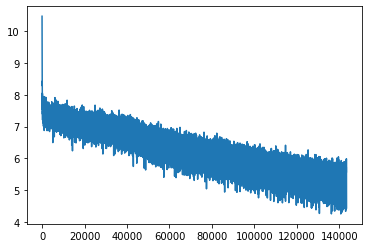

In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [ ]:
# their small model loss